In [4]:
import warnings
warnings.filterwarnings('ignore')
import pickle

In [137]:
pip install pyspellchecker

In [5]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.models import ColorBar, ColumnDataSource
from bokeh.colors import Color

import re

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import casual_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import yaml

from collections import Counter

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  

0it [00:00, ?it/s]

In [138]:
from spellchecker import SpellChecker

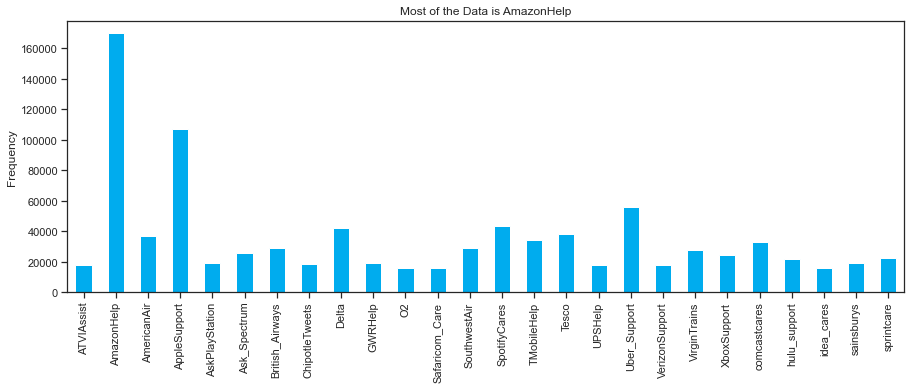

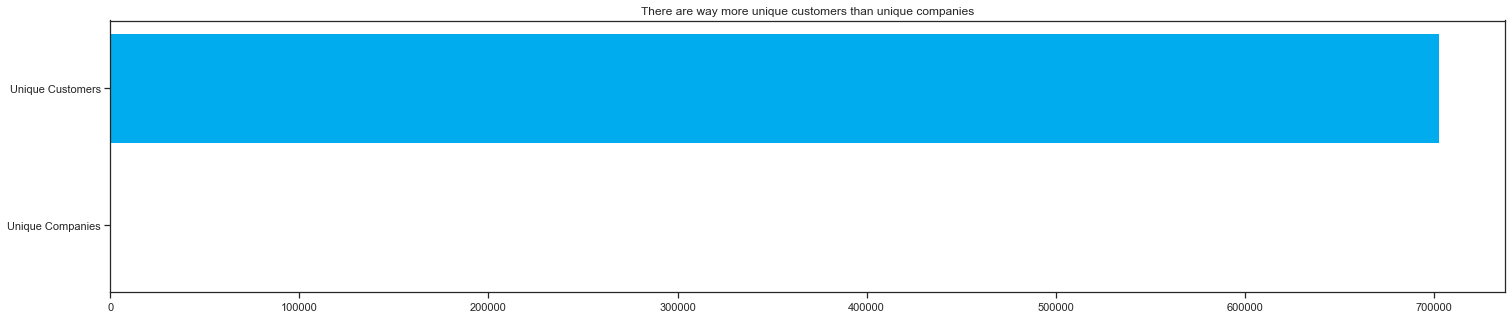

Wall time: 11.6 s


In [6]:
%%time
all_data = pd.read_csv(r'C:\Users\ANILHR\Downloads\twitter\twcs\twcs.csv')

count = all_data.groupby("author_id")["text"].count()

c = count[count>15000].plot(kind='bar',figsize=(15, 5), color='#00acee')
c.set_xlabel('')
c.set_ylabel('Frequency')
plt.title('Most of the Data is AmazonHelp')


plt.show()

authors_count = (len(all_data[all_data.inbound == False].author_id.unique()), len(all_data[all_data.inbound == True].author_id.unique()))

plt.figure(figsize =(25,5))
x = ['Unique Companies','Unique Customers']
ax = plt.barh(x, authors_count, color = '#00acee')
plt.title('There are way more unique customers than unique companies')
plt.show()

In [7]:
# All data shape
print('All data has shape {}'.format(all_data.shape))

# Converting columns to the right datatypes
all_data['text'] = all_data['text'].astype('string')
all_data['author_id'] = all_data['author_id'].astype('string')
all_data.head()


All data has shape (2811774, 7)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [8]:
apple_data = all_data[all_data['author_id'] == 'AppleSupport']
apple_data.shape

(106860, 7)

In [9]:
apple_data.dropna(subset = ['in_response_to_tweet_id'],inplace = True)
apple_data['inbound'].value_counts(), apple_data.shape

(False    106719
 Name: inbound, dtype: int64,
 (106719, 7))

In [10]:
apple_data.in_response_to_tweet_id = apple_data.in_response_to_tweet_id.astype('int64')
apple_data = pd.merge(all_data[['tweet_id','text']],apple_data,left_on='tweet_id', right_on='in_response_to_tweet_id')
apple_data.drop(['tweet_id_x','tweet_id_y','in_response_to_tweet_id','inbound'], axis = 1, inplace = True)
apple_data.rename(columns = {'text_x':'inbound_text','text_y':'outbound_text'},inplace = True)
text = apple_data[['inbound_text','outbound_text']]

#text.to_pickle('objects/raw_text.pkl')
with open('text_pickle','wb') as file:
    pickle.dump(text,file)

inbound = text['inbound_text']
outbound = text['outbound_text']


In [12]:
import pickle
with open('text_pickle','wb') as file:
    pickle.dump(text,file)

In [134]:
text.head()

,inbound_text,outbound_text
0,@AppleSupport The newest update. I️ made sure ...,@115854 Lets take a closer look into this issu...
1,@AppleSupport https://t.co/NV0yucs0lB,@115854 We're here for you. Which version of t...
2,@AppleSupport Tried resetting my settings .. r...,@115855 Let's go to DM for the next steps. DM ...
3,@AppleSupport This is what it looks like https...,@115855 Any steps tried since it started last ...
4,@AppleSupport I️ have an iPhone 7 Plus and yes...,@115855 That's great it has iOS 11.1 as we can...


In [223]:
def remove_links(doc):
    word = re.sub('([\w+]+\:\/\/)?([\w\d-]+\.)*[\w-]+[\.\:]\w+([\/\?\=\&\#\.]?[\w-]+)*\/?', '', doc)
    word = word.split()
    word = " ".join(word)
    return word

In [224]:
def preprocessing(sent):
    
    #word = re.sub(r'^https?:\/\/.*[\r\n]*', '',sent)      
    word = re.sub("[^a-zA-Z]"," ",sent)
    word = word.lower()
    word = word.split()
    word = " ".join(word)
    return word
    

In [142]:
def correct_spellings(x):
    spell = SpellChecker()
    corrected_text = []
    for word in x:
        if word in x:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return corrected_text

In [286]:
from nltk.tokenize import  word_tokenize
import nltk
def lemmatize_list(x):
    lemmatizer = WordNetLemmatizer()
    #x = " ".join(x)
    word = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(x) if not w in stop_word_list]
    return word


def get_wordnet_pos(word):
    
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def limit_length(x, max_tokens, min_tokens):
    output = x
    if len(x) > max_tokens:
        output = np.nan
    if len(x) <= min_tokens:
        output = np.nan
    return output


In [266]:
stop_word_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't","applesupport"]

In [290]:
max_tokens = 50
min_tokens = 2
stopwords.words('english');
stop_words = set(stopwords.words('english')) 

data=inbound

data = data.progress_apply(remove_links)
data = data.progress_apply(preprocessing)

data = data.progress_apply(lemmatize_list)

data = data.progress_apply(limit_length, min_tokens = min_tokens, max_tokens = max_tokens)

data = data.dropna()



  0%|          | 0/106648 [00:00<?, ?it/s]

  0%|          | 0/106648 [00:00<?, ?it/s]

  0%|          | 0/106648 [00:00<?, ?it/s]

  0%|          | 0/106648 [00:00<?, ?it/s]

In [291]:
data[0:10]

0        [new, update, make, sure, download, yesterday]
2                 [try, reset, setting, restart, phone]
4                                   [iphone, plus, yes]
5                                 [need, answer, annoy]
6     [hey, anyone, else, upgraded, issue, capital, ...
8                                 [tf, wrong, keyboard]
9                          [call, centre, close, night]
10                  [hello, line, close, tonight, help]
12    [hello, internet, someone, explain, symbol, ke...
13    [get, screenshot, say, iphonex, reserve, rd, e...
Name: inbound_text, dtype: object

In [298]:
with open('data_pickle','wb') as file:
    pickle.dump(data,file)

In [299]:
with open('data_pickle','rb') as file:
    mp = pickle.load(file)